# Importing dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, classification_report
)

import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
np.random.seed(42)

def summarize_split(y, name):
    y = np.asarray(y)
    churn_rate = y.mean()
    print(f"{name}: n={len(y)} | churn_rate={churn_rate:.3f} | pos={y.sum()} neg={(1-y).sum()}")

def expected_cost(y_true, y_pred, cost_fn=100, cost_fp=10):
    # y_true, y_pred are 0/1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * cost_fn + fp * cost_fp

def find_best_threshold(y_true, y_prob, cost_fn=100, cost_fp=10, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    best = {"threshold": None, "cost": np.inf, "tn":0, "fp":0, "fn":0, "tp":0}
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fn * cost_fn + fp * cost_fp
        if cost < best["cost"]:
            best = {"threshold": float(t), "cost": float(cost), "tn":tn, "fp":fp, "fn":fn, "tp":tp}
    return best

def plot_pr_roc(y_true, y_prob, title_prefix="Model"):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    ax[0].plot([0,1],[0,1], linestyle="--", color="gray")
    ax[0].set_title(f"{title_prefix} ROC")
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[0].legend()

    ax[1].plot(recall, precision, label=f"AP={ap:.3f}")
    ax[1].set_title(f"{title_prefix} Precision-Recall")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].legend()
    plt.tight_layout()
    plt.show()



# Loading Dataset

In [2]:
import pandas as pd
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA + hypotheses (quick)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Churn
No     5174
Yes    1869
Name: count, dtype: int64


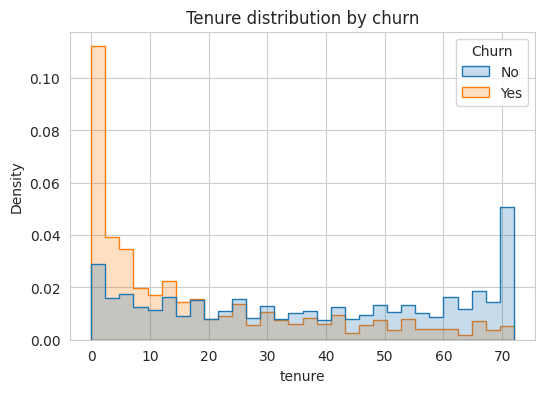

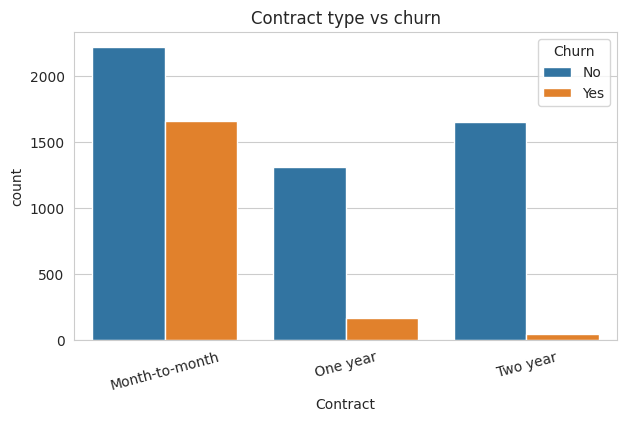

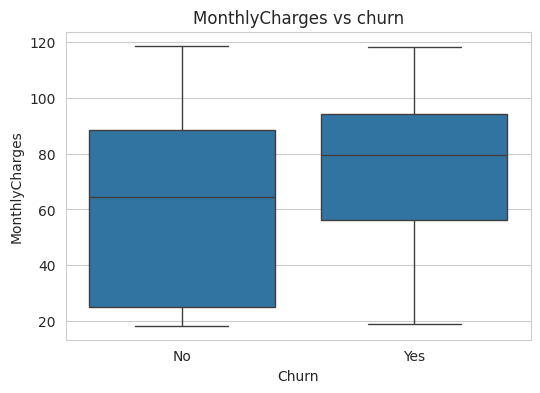

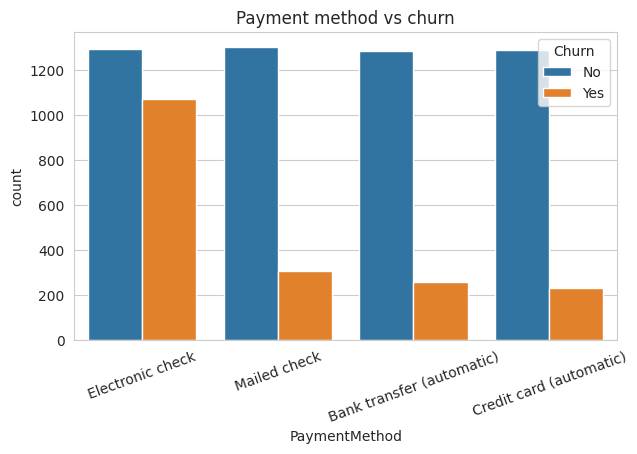


Hypotheses to test:
- Lower tenure => higher churn probability
- Month-to-month contracts => higher churn
- Higher MonthlyCharges => higher churn
- Some payment methods (e-check) => higher churn


In [3]:
df = df.copy()

# Basic cleanup
df.columns = [c.strip() for c in df.columns]

print("Columns:", df.columns.tolist())
print(df["Churn"].value_counts(dropna=False))

# Hypothesis checks (quick visuals)
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, element="step", stat="density", common_norm=False)
plt.title("Tenure distribution by churn")
plt.show()

plt.figure(figsize=(7,4))
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Contract type vs churn")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Churn", y="MonthlyCharges")
plt.title("MonthlyCharges vs churn")
plt.show()

plt.figure(figsize=(7,4))
sns.countplot(data=df, x="PaymentMethod", hue="Churn")
plt.title("Payment method vs churn")
plt.xticks(rotation=20)
plt.show()

print("\nHypotheses to test:")
print("- Lower tenure => higher churn probability")
print("- Month-to-month contracts => higher churn")
print("- Higher MonthlyCharges => higher churn")
print("- Some payment methods (e-check) => higher churn")


# Preprocessing + splits (stratified)

In [4]:
# Target
y = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# Drop obvious ID column if present
for col in ["customerID", "customerId", "CustomerID"]:
    if col in df.columns:
        df = df.drop(columns=[col])

X = df.drop(columns=["Churn"])

# TotalCharges often comes as string with blanks; coerce to numeric
if "TotalCharges" in X.columns:
    X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")

# Identify numeric/categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols[:10], "... total:", len(cat_cols))

# Preprocess pipeline
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ]
)

# Split: train/val/test with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)  # 0.1765 of 0.85 ≈ 0.15 => final 70/15/15-ish

summarize_split(y_train, "Train")
summarize_split(y_val,   "Val")
summarize_split(y_test,  "Test")


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'] ... total: 15
Train: n=4929 | churn_rate=0.265 | pos=1308 neg=3621
Val: n=1057 | churn_rate=0.266 | pos=281 neg=776
Test: n=1057 | churn_rate=0.265 | pos=280 neg=777


# Baseline: Logistic Regression (with/without class_weight)

LR plain ROC-AUC: 0.8296630223428845
LR balanced ROC-AUC: 0.8291860806398356


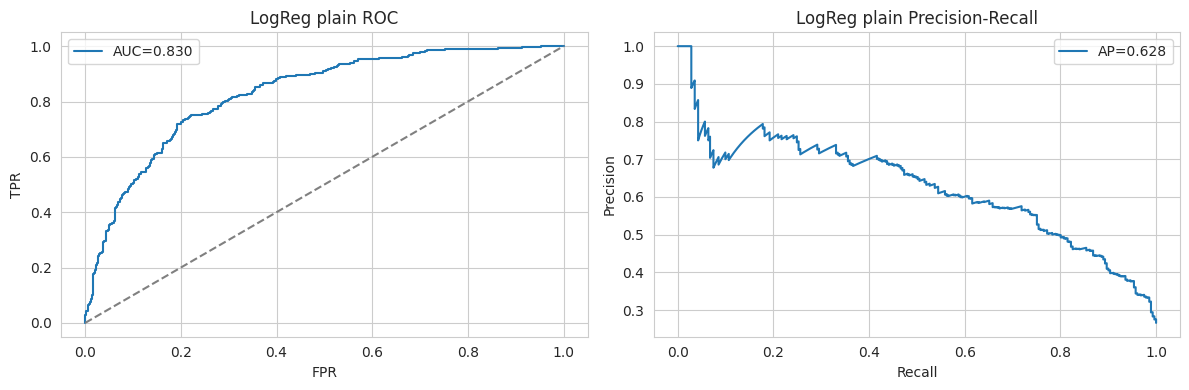

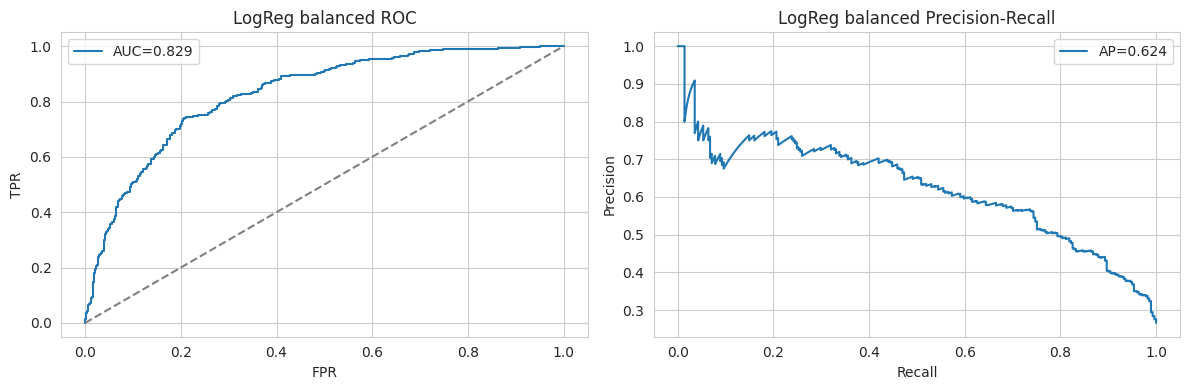

In [5]:
# Logistic Regression baseline
lr_plain = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

lr_bal = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced"))
])

lr_plain.fit(X_train, y_train)
lr_bal.fit(X_train, y_train)

val_prob_plain = lr_plain.predict_proba(X_val)[:,1]
val_prob_bal   = lr_bal.predict_proba(X_val)[:,1]

print("LR plain ROC-AUC:", roc_auc_score(y_val, val_prob_plain))
print("LR balanced ROC-AUC:", roc_auc_score(y_val, val_prob_bal))

plot_pr_roc(y_val, val_prob_plain, "LogReg plain")
plot_pr_roc(y_val, val_prob_bal,   "LogReg balanced")


# Interpretability: odds ratios (top coefficients)

In [6]:
# Get feature names after preprocessing
ohe = lr_bal.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([np.array(num_cols), cat_feature_names])

coefs = lr_bal.named_steps["clf"].coef_.ravel()
odds_ratio = np.exp(coefs)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "odds_ratio": odds_ratio
}).sort_values("odds_ratio", ascending=False)

print("Top churn-increasing features (highest odds ratio):")
display(coef_df.head(15))

print("\nTop churn-decreasing features (lowest odds ratio):")
display(coef_df.tail(15).sort_values("odds_ratio"))


Top churn-increasing features (highest odds ratio):


,feature,coef,odds_ratio
36,Contract_Month-to-month,0.717205,2.048699
16,InternetService_Fiber optic,0.590286,1.804504
3,TotalCharges,0.477568,1.612149
43,PaymentMethod_Electronic check,0.226721,1.254479
35,StreamingMovies_Yes,0.224388,1.251557
32,StreamingTV_Yes,0.201859,1.223676
27,TechSupport_No,0.184392,1.202488
18,OnlineSecurity_No,0.171913,1.187575
40,PaperlessBilling_Yes,0.088756,1.092814
26,DeviceProtection_Yes,0.065428,1.067616



Top churn-decreasing features (lowest odds ratio):


,feature,coef,odds_ratio
1,tenure,-1.150162,0.316585
38,Contract_Two year,-0.798168,0.450153
15,InternetService_DSL,-0.535355,0.585461
2,MonthlyCharges,-0.431522,0.649520
39,PaperlessBilling_No,-0.266954,0.765708
34,StreamingMovies_No internet service,-0.233128,0.792052
19,OnlineSecurity_No internet service,-0.233128,0.792052
17,InternetService_No,-0.233128,0.792052
28,TechSupport_No internet service,-0.233128,0.792052
22,OnlineBackup_No internet service,-0.233128,0.792052


# Advanced model: XGBoost (cost-sensitive via scale_pos_weight)

XGB ROC-AUC: 0.8277139817294641


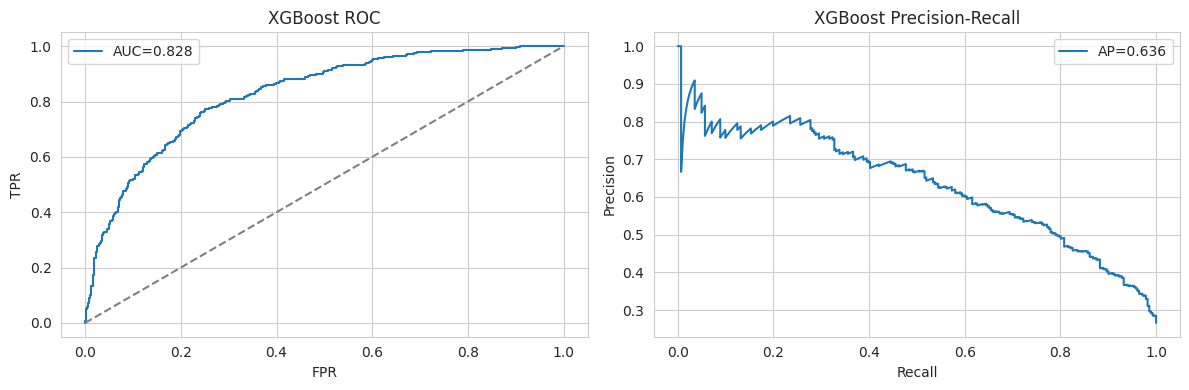

In [7]:
pos = y_train.sum()
neg = (1 - y_train).sum()
scale_pos_weight = neg / pos

xgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1.0,
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    ))
])

xgb.fit(X_train, y_train)
val_prob_xgb = xgb.predict_proba(X_val)[:,1]

print("XGB ROC-AUC:", roc_auc_score(y_val, val_prob_xgb))
plot_pr_roc(y_val, val_prob_xgb, "XGBoost")


# Cost-sensitive threshold optimization (+ sensitivity)

In [8]:
# Define business costs
COST_FN = 100   # missing a churner
COST_FP = 10    # offering incentive to non-churner

best_lr = find_best_threshold(y_val, val_prob_bal, cost_fn=COST_FN, cost_fp=COST_FP)
best_xgb = find_best_threshold(y_val, val_prob_xgb, cost_fn=COST_FN, cost_fp=COST_FP)

print("Best threshold (LR balanced):", best_lr)
print("Best threshold (XGB):", best_xgb)

# Compare default vs optimal on validation
def report_at_threshold(name, y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    cost = expected_cost(y_true, y_hat, COST_FN, COST_FP)
    print(f"\n{name} @ thr={thr:.2f}")
    print("Confusion:", {"tn":tn,"fp":fp,"fn":fn,"tp":tp})
    print("Expected cost:", cost)
    print(classification_report(y_true, y_hat, digits=3))

report_at_threshold("LR balanced", y_val, val_prob_bal, 0.50)
report_at_threshold("LR balanced", y_val, val_prob_bal, best_lr["threshold"])

report_at_threshold("XGB", y_val, val_prob_xgb, 0.50)
report_at_threshold("XGB", y_val, val_prob_xgb, best_xgb["threshold"])

# Sensitivity analysis: vary FN/FP ratio
ratios = [2, 5, 10, 20, 50]
sens = []
for r in ratios:
    b = find_best_threshold(y_val, val_prob_xgb, cost_fn=10*r, cost_fp=10)
    sens.append((r, b["threshold"], b["cost"]))
sens_df = pd.DataFrame(sens, columns=["FN_to_FP_ratio", "best_threshold", "min_cost"])
sens_df


Best threshold (LR balanced): {'threshold': 0.18000000000000002, 'cost': 5880.0, 'tn': np.int64(328), 'fp': np.int64(448), 'fn': np.int64(14), 'tp': np.int64(267)}
Best threshold (XGB): {'threshold': 0.06999999999999999, 'cost': 5990.0, 'tn': np.int64(287), 'fp': np.int64(489), 'fn': np.int64(11), 'tp': np.int64(270)}

LR balanced @ thr=0.50
Confusion: {'tn': np.int64(569), 'fp': np.int64(207), 'fn': np.int64(65), 'tp': np.int64(216)}
Expected cost: 8570
              precision    recall  f1-score   support

           0      0.897     0.733     0.807       776
           1      0.511     0.769     0.614       281

    accuracy                          0.743      1057
   macro avg      0.704     0.751     0.710      1057
weighted avg      0.795     0.743     0.756      1057


LR balanced @ thr=0.18
Confusion: {'tn': np.int64(328), 'fp': np.int64(448), 'fn': np.int64(14), 'tp': np.int64(267)}
Expected cost: 5880
              precision    recall  f1-score   support

           0      0.

,FN_to_FP_ratio,best_threshold,min_cost
0,2,0.49,3220.0
1,5,0.23,4880.0
2,10,0.07,5990.0
3,20,0.04,6690.0
4,50,0.01,7930.0


# Retention strategy simulation (budget constrained)

In [9]:
# --- FIXED RETENTION SIMULATION (Cell 10) ---
# Works by writing decisions directly into val_sorted["targeted"]
# so it always matches dataframe length/index.

val_df_sim = X_val.copy()
val_df_sim["y_true"] = y_val.values
val_df_sim["p_churn"] = val_prob_xgb

# Simple customer value proxy: TotalCharges (or MonthlyCharges * tenure)
if "TotalCharges" in val_df_sim.columns:
    val_df_sim["value"] = pd.to_numeric(val_df_sim["TotalCharges"], errors="coerce").fillna(0)
else:
    val_df_sim["value"] = val_df_sim["MonthlyCharges"] * val_df_sim["tenure"]

# Risk buckets (low/medium/high)
val_df_sim["risk_bucket"] = pd.cut(
    val_df_sim["p_churn"],
    bins=[-np.inf, 0.40, 0.70, np.inf],
    labels=["low", "medium", "high"]
)

# Intervention policy
BUDGET = 50000
offers = {"high": 30, "medium": 15, "low": 0}

# Targeting score: expected preventable loss proxy
val_df_sim["score_for_targeting"] = val_df_sim["p_churn"] * val_df_sim["value"]

# Sort ONCE, and operate only on this dataframe
val_sorted = val_df_sim.sort_values("score_for_targeting", ascending=False).copy()

# Offer cost per row
val_sorted["offer_cost_unit"] = (
    val_sorted["risk_bucket"].astype(str).map(offers).fillna(0).astype(int)
)

# Initialize targeted aligned to index
val_sorted["targeted"] = 0

spent = 0
for idx, row in val_sorted.iterrows():
    c = int(row["offer_cost_unit"])
    if c <= 0:
        continue
    if spent + c <= BUDGET:
        val_sorted.at[idx, "targeted"] = 1
        spent += c

print("Budget:", BUDGET, "Spent:", spent, "Targeted customers:", int(val_sorted["targeted"].sum()))

# Simulate retention effectiveness (assumption)
LIFT = 0.35  # 35% of targeted would-be churners retained
rng = np.random.default_rng(42)

val_sorted["saved_churn"] = (
    (val_sorted["targeted"] == 1) &
    (val_sorted["y_true"] == 1) &
    (rng.random(len(val_sorted)) < LIFT)
).astype(int)

# Financial simulation
val_sorted["offer_cost"] = val_sorted["offer_cost_unit"] * val_sorted["targeted"]
val_sorted["gain"] = val_sorted["saved_churn"] * val_sorted["value"]

net_gain = val_sorted["gain"].sum() - val_sorted["offer_cost"].sum()
roi = val_sorted["gain"].sum() / max(val_sorted["offer_cost"].sum(), 1)

print("Total avoided churn (simulated):", int(val_sorted["saved_churn"].sum()))
print("Total gain:", float(val_sorted["gain"].sum()))
print("Total offer cost:", float(val_sorted["offer_cost"].sum()))
print("Net gain:", float(net_gain))
print("ROI (gain/cost):", float(roi))

val_sorted[["p_churn","value","risk_bucket","targeted","saved_churn","offer_cost","gain"]].head(10)


Budget: 50000 Spent: 10320 Targeted customers: 455
Total avoided churn (simulated): 77
Total gain: 94164.45
Total offer cost: 10320.0
Net gain: 83844.45
ROI (gain/cost): 9.124462209302326


,p_churn,value,risk_bucket,targeted,saved_churn,offer_cost,gain
3783,0.783341,6936.85,high,1,0,30,0.00
6032,0.679600,7299.65,medium,1,0,15,0.00
2860,0.700768,6841.05,high,1,0,30,0.00
6035,0.625149,7491.75,medium,1,0,15,0.00
2075,0.781220,5594.00,high,1,0,30,0.00
6342,0.847027,5135.15,high,1,0,30,0.00
3200,0.812503,5278.15,high,1,0,30,0.00
5298,0.666138,6401.25,medium,1,0,15,0.00
6453,0.874863,4871.05,high,1,1,30,4871.05
4502,0.777462,5283.95,high,1,0,30,0.00


# SHAP explainability (XGBoost global + local)

/tmp/ipython-input-3935866912.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_enc, feature_names=feature_names, show=False)


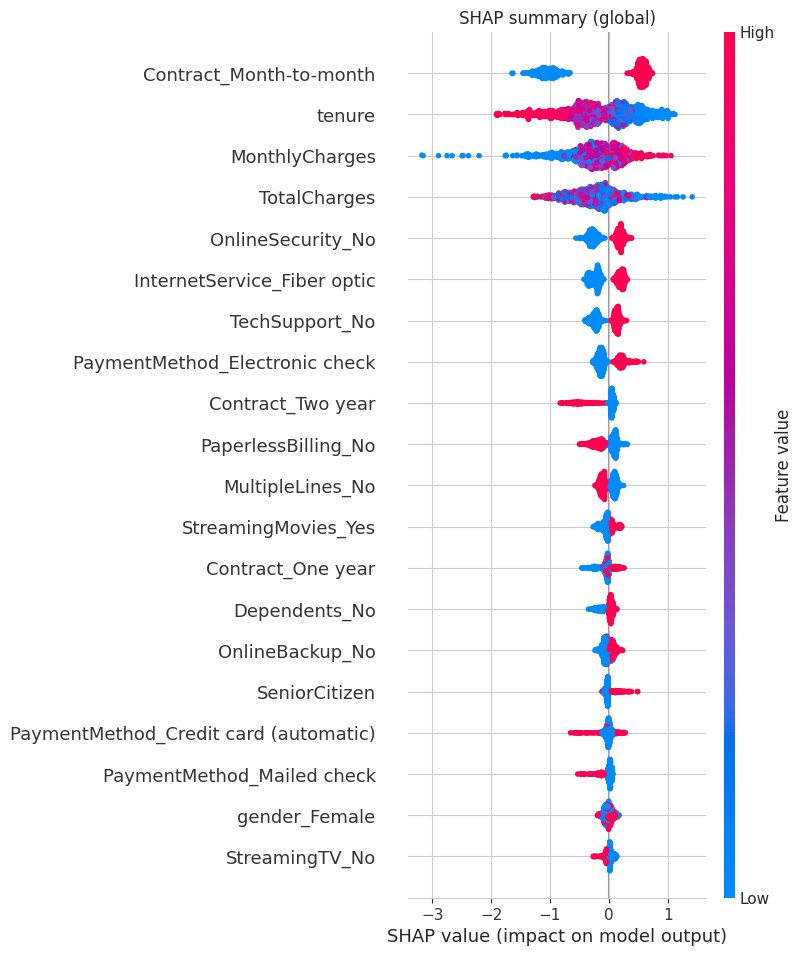

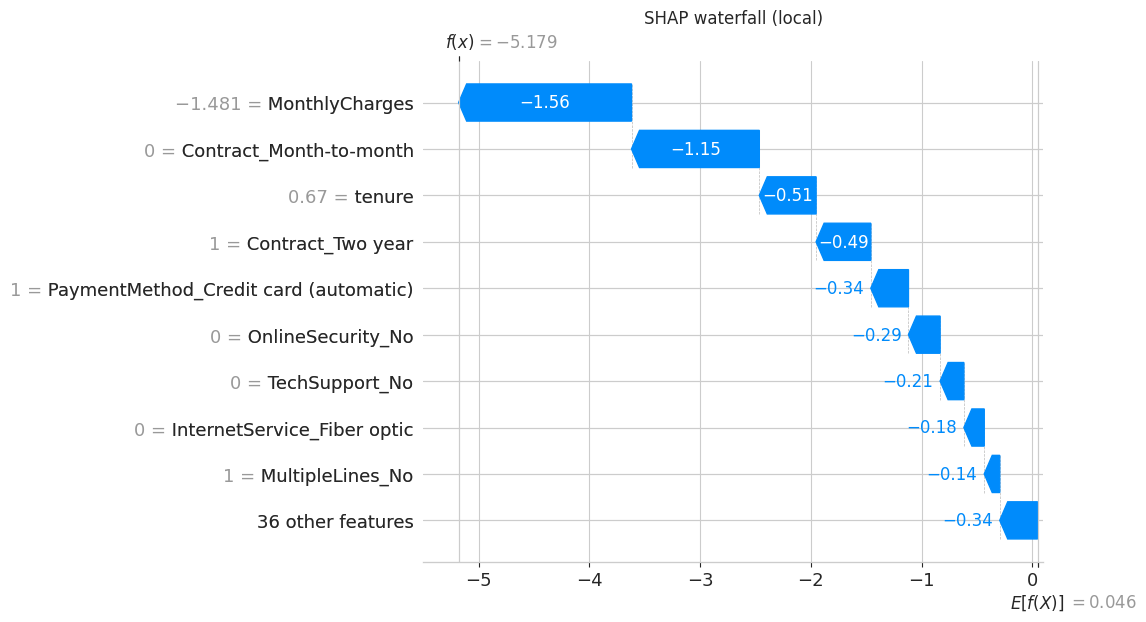

In [10]:
# Transform data once using the preprocessing step
X_train_enc = xgb.named_steps["prep"].fit_transform(X_train)  # fit already done, safe
X_val_enc   = xgb.named_steps["prep"].transform(X_val)

# Feature names
ohe = xgb.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([np.array(num_cols), cat_feature_names])

# SHAP TreeExplainer for XGBoost model
model = xgb.named_steps["clf"]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_enc)

# Global importance (summary plot)
shap.summary_plot(shap_values, X_val_enc, feature_names=feature_names, show=False)
plt.title("SHAP summary (global)")
plt.show()

# Local explanation for one customer
idx = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[idx],
                                     base_values=explainer.expected_value,
                                     data=X_val_enc[idx].toarray().ravel() if hasattr(X_val_enc[idx], "toarray") else X_val_enc[idx],
                                     feature_names=feature_names),
                    show=False)
plt.title("SHAP waterfall (local)")
plt.show()


# Final test evaluation

Test ROC-AUC: 0.8403359992645708
Test AP: 0.644505460907879
Using threshold: 0.06999999999999999
Confusion matrix:
 [[274 503]
 [  5 275]]
Expected cost: 5530
              precision    recall  f1-score   support

           0      0.982     0.353     0.519       777
           1      0.353     0.982     0.520       280

    accuracy                          0.519      1057
   macro avg      0.668     0.667     0.519      1057
weighted avg      0.816     0.519     0.519      1057



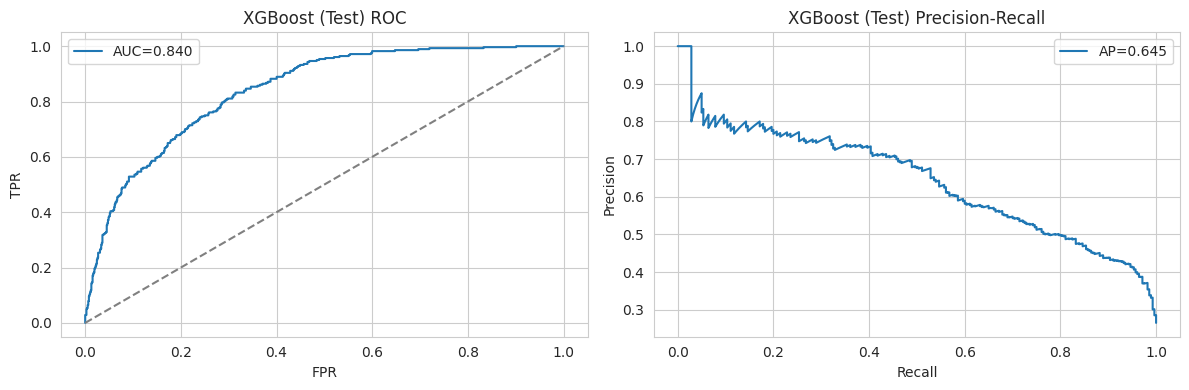

In [11]:
test_prob = xgb.predict_proba(X_test)[:,1]

best_thr = find_best_threshold(y_val, val_prob_xgb, cost_fn=COST_FN, cost_fp=COST_FP)["threshold"]
y_test_hat = (test_prob >= best_thr).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, test_prob))
print("Test AP:", average_precision_score(y_test, test_prob))
print("Using threshold:", best_thr)

print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hat))
print("Expected cost:", expected_cost(y_test, y_test_hat, COST_FN, COST_FP))
print(classification_report(y_test, y_test_hat, digits=3))

plot_pr_roc(y_test, test_prob, "XGBoost (Test)")
